In [1]:
# Initial setup of copula generative model based on parametric distributions for larger set of variables
# Extension to parametric design context
#
# Author: Alex Braafladt
#
# Version: v1 Initial creation 3/11/2022
#          v2 First draft with all components for nonparametric experiment for continuous case 3/14/2022
#          v3 Draft with updates for hosting on GitHub 5/2/2022
#
# References:
#   -https://openturns.github.io/openturns/latest/theory/probabilistic_modeling/copulas.html#copula
#   -https://openturns.github.io/openturns/latest/auto_probabilistic_modeling/copulas/plot_composed_copula.html
#   -https://en.wikipedia.org/wiki/Copula_(probability_theory)

# Parametric order reduction with emulator data

Extension of order reduction approach to design context with parametricly varying input variables. Structured OR approach tested with hypothesis of using empirical probability density functions, and falsified, prompting an alternative hypothesis

In [34]:
# probabilistic and statistical modeling
import openturns as ot
import openturns.viewer as viewer
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as st
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

# data and numerical functions
import numpy as np
import pandas as pd

# graphing and visualization functions
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText

# order reduction and data conditioners
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

# design of experiments
from doepy import build

# os operations
import os as os
import sys
import datetime as dt
import pickle
from joblib import dump, load

# custom functions
import stats_functions as sf
import copula_gen_data as cpgen
from emulator_classes import Simulation, Data, Experiment

In [3]:
# directory setup

# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'parOR' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\distribution-surrogates
Data save directory: C:\Users\alexb\PycharmProjects\distribution-surrogates\output\\parOR20220510161801


In [4]:
%%time
# generate parametric data
input_ranges = np.array([[500.0, 55000.0], [100.0, 7000.0], [-5.0,3.0], [0.1, 0.9], [0.0, 0.5],
                         [40.0, 80.0], [0.5, 1.5], [1.0, 4.0], [0.5, 1.5], [2.0, 3.0],
                         [0.2, 0.8], [0.4, 0.8], [1., 15.], [7., 10.], [1., 10.]])

# flag which distributions are discrete for later use in analysis
discrete_flags = []
for i in range(25):
    discrete_flags.append(False)
for i in range(5):
    discrete_flags.append(True)

parametric_experiment = Experiment(input_ranges, num_cases=1000, discrete_flags=discrete_flags)
parametric_experiment.generate_data()
exp_data = parametric_experiment.data

CPU times: total: 2min 55s
Wall time: 41 s


#### Attempt at order reduction with parametric data
In the parametric case, the data is instead stacked into snapshots to identify a basis for the **set** of distributions generated by each simulation run. However, the histogram structuring approach runs into a problem here which will be shown below.

In [5]:
# show error that results from histogram structuring approach

# structuring data across all cases ranges for the histogram bins
# get full set bins
raw_data = exp_data.scaled_samples
split_data_by_case = np.split(raw_data, raw_data.shape[0], axis=0)
split_data_by_case = [elem[0] for elem in split_data_by_case]
data_np_dists = np.concatenate(split_data_by_case, axis=0)
def get_global_bins(arr):
    _, bins = np.histogram(arr,bins=50)
    return bins
epdf_global_bins = np.apply_along_axis(get_global_bins, arr=data_np_dists, axis=0)
epdf_global_bins = np.split(epdf_global_bins, epdf_global_bins.shape[1], axis=1)
# structure data accordingly
split_data_by_dist = np.split(raw_data, raw_data.shape[2], axis=2)
split_data_by_dist = [elem[:,:,0] for elem in split_data_by_dist]
# pair bins and data
paired_data = list(zip(epdf_global_bins, split_data_by_dist))
# structure data
# structured_data = [sf.get_epdf_probs(t[1][:,0], t[0][:,0]) for t in paired_data]
structured_data = [np.apply_along_axis(sf.get_epdf_probs, arr=t[1], bins=t[0][:,0], axis=1) for t in paired_data]
structured_data = np.stack(structured_data, axis=2)

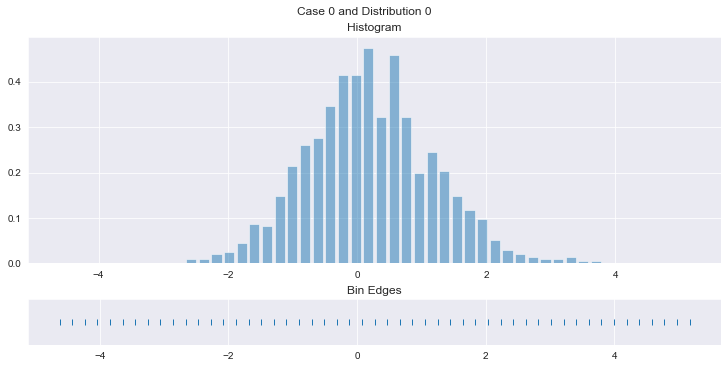

In [6]:
# plot case with where structuring works as desired
case_to_plot = 0
dist_to_plot = 0
title = "Case " + str(case_to_plot) + " and Distribution " + str(dist_to_plot)
# plot example of epdf structure
fig1, ax1 = plt.subplots(2,1, figsize=(10,5), constrained_layout=True, gridspec_kw={'height_ratios':[5,1]})
ax = ax1.ravel()
center = ( (epdf_global_bins[dist_to_plot][:-1] + epdf_global_bins[dist_to_plot][1:])/2.0 )[:,0]
width = (epdf_global_bins[dist_to_plot][1] - epdf_global_bins[dist_to_plot][0])*0.8
ax[0].bar(center, structured_data[case_to_plot,:,dist_to_plot], alpha=0.5, width=width, label='Probabilities in bins')
ax[0].set_title("Histogram")
ax[1].plot(epdf_global_bins[dist_to_plot], np.zeros_like(epdf_global_bins[dist_to_plot]), '|', label='Bin edges')
ax[1].set_title('Bin Edges')
ax[1].set_yticks(())
plt.suptitle(title)
plot_title = 'Case ' + str(case_to_plot) + ' Distribution ' + str(dist_to_plot) + ' Histogram-Bin-Comparison'

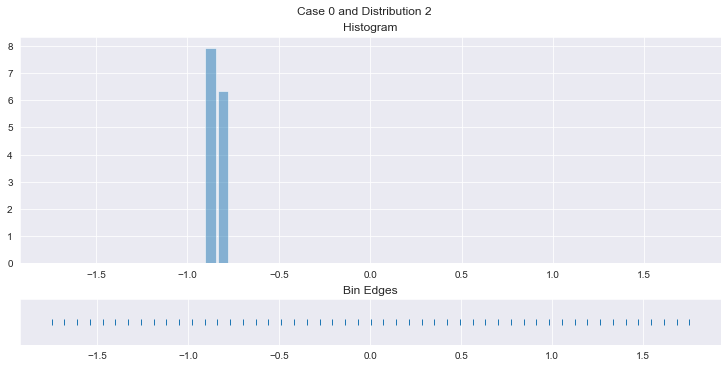

In [7]:
# plot case with resolution difficulty
case_to_plot = 0
dist_to_plot = 2
title = "Case " + str(case_to_plot) + " and Distribution " + str(dist_to_plot)
# plot example of epdf structure
fig2, ax2 = plt.subplots(2,1, figsize=(10,5), constrained_layout=True, gridspec_kw={'height_ratios':[5,1]})
ax = ax2.ravel()
center = ( (epdf_global_bins[dist_to_plot][:-1] + epdf_global_bins[dist_to_plot][1:])/2.0 )[:,0]
width = (epdf_global_bins[dist_to_plot][1] - epdf_global_bins[dist_to_plot][0])*0.8
ax[0].bar(center, structured_data[case_to_plot,:,dist_to_plot], alpha=0.5, width=width, label='Probabilities in bins')
ax[0].set_title("Histogram")
ax[1].plot(epdf_global_bins[dist_to_plot], np.zeros_like(epdf_global_bins[dist_to_plot]), '|', label='Bin edges')
ax[1].set_title('Bin Edges')
ax[1].set_yticks(())
plt.suptitle(title)
plot_title = 'Case ' + str(case_to_plot) + ' Distribution ' + str(dist_to_plot) + ' Histogram-Bin-Comparison'

In [8]:
#todo - add Bokeh interactive plot

#### Falsified hypothesis 1
The structuring approach that formed a part of the hypothesis for working effectively order reduction was based on defining the histogram bins based on the full training dataset (so as to be able to recover those bins for any interpolated distribution). However, this leads to cases where the resolution of the histograms is lost when there is enough mean shift across the cases in the dataset. Having falsified this hypothesis, an alternative hypothesis is generated and considered next.

## Alternative hypothesis 1
A set of alternatives were generated as options to enable the feasibility of order reduction with the stochastic distributions after falsifying the original approach. Please reach out to request the details if desired, but the most promising alternative was structuring using empirical cumulative distribution functions (ecdfs). This separates the structure into two components, the x-values of the ecdf, and y-values that depend solely on the number of samples included in the data used to generate the ecdf. This separation allows the only piece of information needed in the modeling process to be the ecdf x-values.

In [9]:
# alternative hypothesis with ecdf structuring approach

# structuring data across all cases based on ecdfs
ecdf_y, ecdfx_true = exp_data.scaled_ecdfs

Text(0.5, 0.98, 'Structured Representation: Case 0 and Distribution 2')

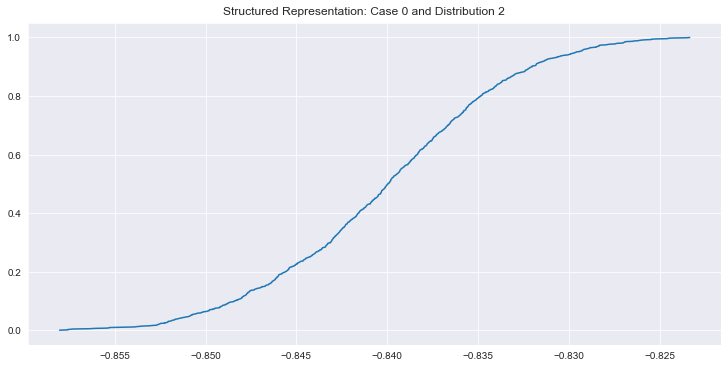

In [10]:
# plot case example
case_to_plot = 0
dist_to_plot = 2
title = "Structured Representation: Case " + str(case_to_plot) + " and Distribution " + str(dist_to_plot)
# plot example of epdf structure
fig3, ax3 = plt.subplots(1,1, figsize=(10,5), constrained_layout=True)
ax3.plot(ecdfx_true[case_to_plot,:,dist_to_plot], ecdf_y)
plt.suptitle(title)

In [11]:
# sweep through OR RIC levels with data to show performance of approach

# define the OR properties
req_ric = 0.9999
pca = PCA(req_ric)

# set up data for OR
data_for_pca = cpgen.pca_stack(ecdfx_true)

# run the OR
pca.fit(data_for_pca)
print('Number of components needed for retaining ', req_ric, ' RIC: ', pca.n_components_, ' of ', data_for_pca.shape[1])

Number of components needed for retaining  0.9999  RIC:  686  of  1000


In [12]:
%%time
# transform the data based on PCA
latent_data = pca.transform(data_for_pca)
ecdfx_approx = cpgen.pca_destack(pca.inverse_transform(latent_data), ecdfx_true.shape[1], ecdfx_true.shape[2])

or_model_data = Data(ecdf_vals=(ecdf_y, ecdfx_approx),
                     discrete_flags=exp_data.discrete_flags,
                     custom_scaler=exp_data.scaler,
                     custom_bins=exp_data.custom_bins)
or_model_data.data_setup_from_ecdfs()

CPU times: total: 5min 41s
Wall time: 5min 38s


In [13]:
# get ecdf predictions
ecdf_y_, ecdfx_or = or_model_data.scaled_ecdfs

Text(0.5, 0.98, 'Case 0 and Distribution 12')

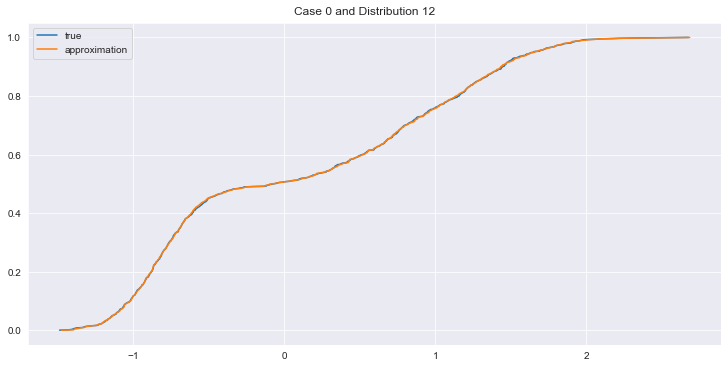

In [14]:
# plot one comparison
case_to_plot = 0
dist_to_plot = 12
title = "Case " + str(case_to_plot) + " and Distribution " + str(dist_to_plot)
# plot example of epdf structure
fig4, ax4 = plt.subplots(1,1, figsize=(10,5), constrained_layout=True)
ax4.plot(ecdfx_true[case_to_plot,:,dist_to_plot], ecdf_y, label='true')
ax4.plot(ecdfx_or[case_to_plot,:,dist_to_plot], ecdf_y, label='approximation')
ax4.legend()
plt.suptitle(title)

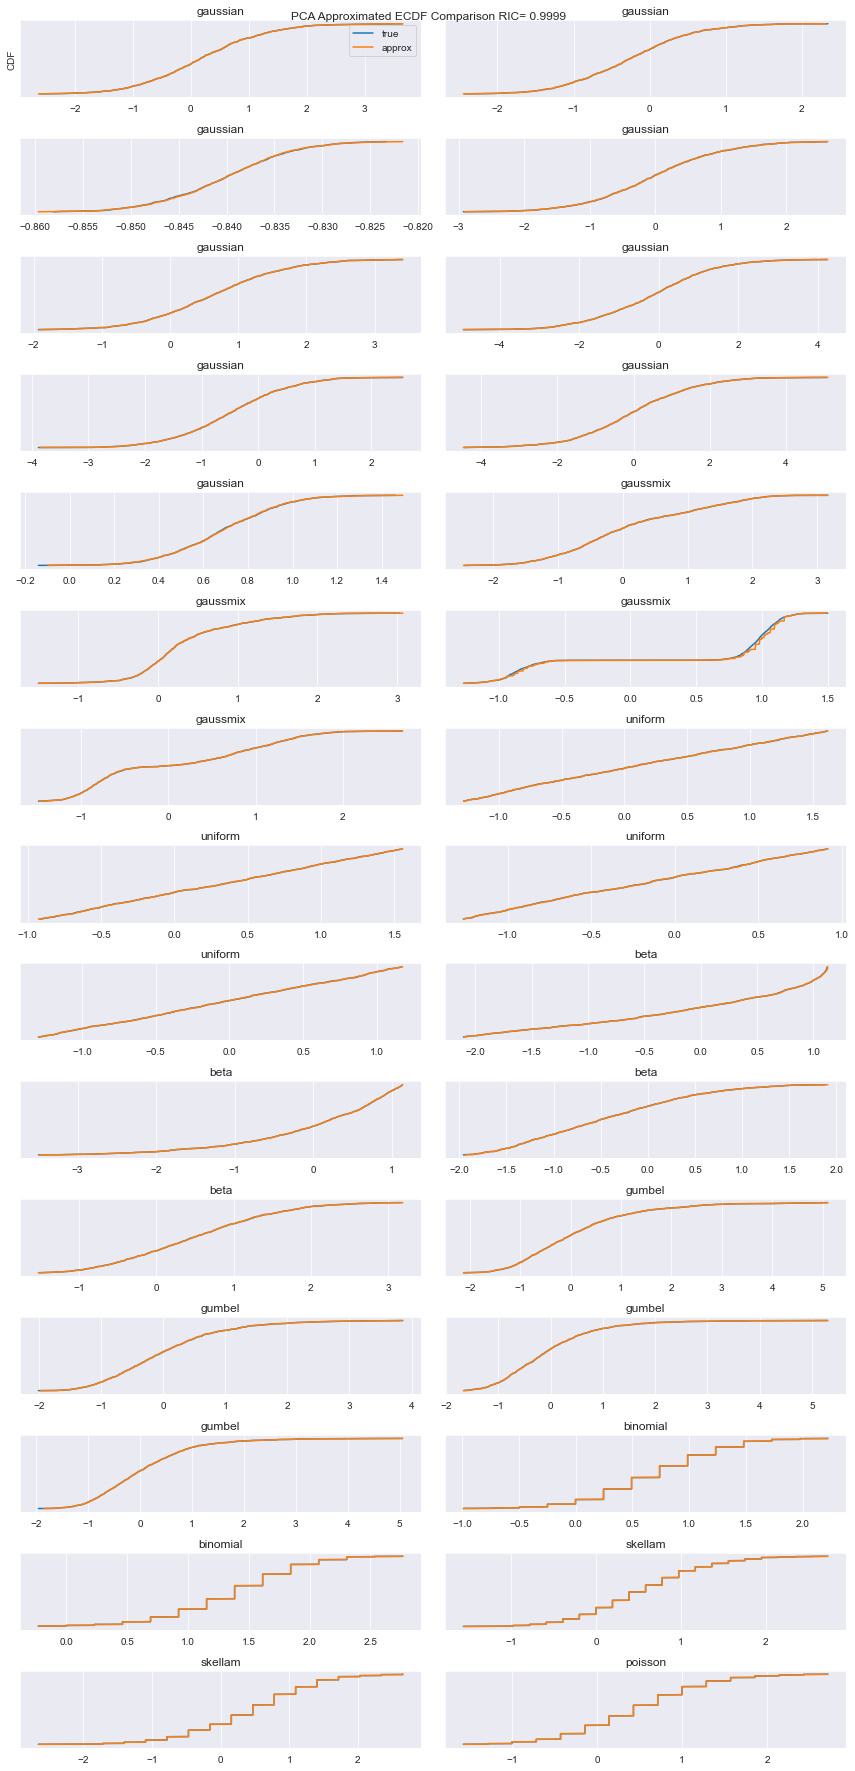

In [15]:
# plot a set of comparisons
case_to_plot = 0
fig5, ax5 = plt.subplots(15, 2, figsize=(12,25))
ax = ax5.ravel()
for i in range(30):
    ax[i].plot(ecdfx_true[case_to_plot,:,i], ecdf_y)
    ax[i].plot(ecdfx_or[case_to_plot,:,i], ecdf_y)
    ax[i].set_title(parametric_experiment.simulations[0].distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_ylabel("CDF")
ax[0].legend(['true', 'approx'], loc='best')
fig5.suptitle('PCA Approximated ECDF Comparison RIC= '+str(req_ric))
fig5.tight_layout()

#### Order reduction model goodness-of-fit
The basic performance of the structured modeling approach is baked into the RIC maintained, and is qualitatively shown in the comparison figures that can be interactively updated to look through all the training data above.

However, the statistical consistency also needs to meet reason-ability requirements in tandem with visual inspection. This is done here using a comparison to data which is from an additional independent sample from the simulations defined in the experiment.

In [16]:
# current data
original_data = exp_data
or_approx_data = or_model_data

# comparison data - using same setup as original data
comparison_experiment = Experiment(input_ranges, num_cases=1000, discrete_flags=discrete_flags,
                                   custom_bins=original_data.custom_bins, custom_doe=parametric_experiment.doe_table)
comparison_experiment.generate_data()
comparison_data = comparison_experiment.data

Using custom DOE table


In [43]:
def calc_ks(true_sample_arr, approx_sample_arr):
    """Calculate the KS metric - based on input 3d arrays of samples"""
    ks_metric_holder = np.ones((true_sample_arr.shape[0], 1, true_sample_arr.shape[2]))
    for i in range(true_sample_arr.shape[0]):
        for j in range(true_sample_arr.shape[2]):
            ks_m, ks_p = st.ks_2samp(true_sample_arr[i, :, j], approx_sample_arr[i, :, j])
            ks_metric_holder[i, 0, j] = ks_m
    return ks_metric_holder


def calc_js(true_epdf_arr, approx_epdf_arr):
    """Calculate the JS metric - based on input 3d arrays of epdf probs with same bins"""
    js_metric_holder = np.ones((true_epdf_arr.shape[0], 1, true_epdf_arr.shape[2]))
    for i in range(true_epdf_arr.shape[0]):
        for j in range(true_epdf_arr.shape[2]):
            js_d = sf.compute_js_dist(true_epdf_arr[i, :, j], approx_epdf_arr[i, :, j])
            js_metric_holder[i, 0, j] = js_d
    return js_metric_holder


def get_initial_diff_df(arr, test_type_label='ks', cross_val_label='train', comparison_label='model'):
    """Convert a 3d array into a df based on input labels"""
    df = pd.DataFrame(arr.ravel(order='F').reshape((arr.shape[2], arr.shape[0])).T.flatten(), columns=['metric'])
    df['test_type'] = test_type_label
    df['cross_val'] = cross_val_label
    df['comparison'] = comparison_label
    return df


class Analysis:
    """
    Object to Data classes and use them to generate plots and goodness-of-fit metrics, and also
    include a function to generate data to drive an interactive dash plot

    Attributes
    ----------

    Methods
    -------

    """
    def __init__(self, true_data=None, comparison_data=None, model_data=None, cross_val_type=None):
        self.true_data = true_data
        self.comparison_data = comparison_data
        self.model_data = model_data
        self.model_ks = None
        self.model_js = None
        self.comparison_ks = None
        self.comparison_js = None
        self.differencing_df = None
        self.cross_val_type = cross_val_type
        self.percent_reasonable_model_ks = None
        self.percent_reasonable_model_js = None

    def calc_differencing_metrics(self):
        """Calculate the KS or JS differencing metrics based comparing Data objects"""
        start_time = dt.datetime.now()
        self.model_ks = calc_ks(self.true_data.scaled_samples, self.model_data.scaled_samples)
        self.model_js = calc_js(self.true_data.scaled_epdfs[1], self.model_data.scaled_epdfs[1])
        self.comparison_ks = calc_ks(self.true_data.scaled_samples, self.comparison_data.scaled_samples)
        self.comparison_js = calc_js(self.true_data.scaled_epdfs[1], self.comparison_data.scaled_epdfs[1])
        elapsed_time = dt.datetime.now() - start_time
        print("Time to calculate differencing metrics: ", elapsed_time)

    def get_differencing_df(self):
        """Combine differencing metrics into a pd.DataFrame for connecting to plotting"""
        dfs_to_combine = [get_initial_diff_df(self.comparison_ks, test_type_label='ks',
                                              cross_val_label=self.cross_val_type, comparison_label='true'),
                          get_initial_diff_df(self.comparison_js, test_type_label='js',
                                              cross_val_label=self.cross_val_type, comparison_label='true'),
                          get_initial_diff_df(self.model_ks, test_type_label='ks',
                                              cross_val_label=self.cross_val_type, comparison_label='model'),
                          get_initial_diff_df(self.model_js, test_type_label='js',
                                              cross_val_label=self.cross_val_type, comparison_label='model')]
        self.differencing_df = pd.concat(dfs_to_combine, axis=0)
        return self.differencing_df

    def get_percent_reasonable(self):
        """Calculate the percentage of model data that is at least as close as the farthest true data for
        each test type"""
        benchmark_ks = np.nanmax(self.comparison_ks)
        benchmark_js = np.nanmax(self.comparison_js)

        model_outliers_locations_ks = np.where(self.model_ks < benchmark_ks)
        model_outliers_locations_js = np.where(self.model_js < benchmark_js)
        num_model_outliers_ks = len(self.model_ks[model_outliers_locations_ks])
        num_model_outliers_js = len(self.model_js[model_outliers_locations_js])
        self.percent_reasonable_model_ks = 100. * (num_model_outliers_ks / self.model_ks.size)
        self.percent_reasonable_model_js = 100. * (num_model_outliers_js / self.model_js.size)

    def plot_single_stat_consistency_comparison(self):
        """Plot the comparison of statistical consistency for KS and JS for one crossval type"""
        # main violin plots
        g = sns.catplot(data=self.differencing_df, x='test_type', y='metric', hue='comparison', palette='Set3',
                        height=8, aspect=1.0, inner='quartile', col='cross_val', kind='violin')
        (g.set_axis_labels("", "")
          .set_xticklabels(["Kolmogorov-Smirnov\nmetric", "Jensen-Shannon\ndistance"], size=17)
          .set(ylim=(0,1))
          ._legend.remove())
        plt.legend(fontsize=18)
        # add ks metric results annotation
        ks_anno = "{:.0f}".format(self.percent_reasonable_model_ks) +\
                  '% of modeled distributions\nas close as farthest true'
        at_ks = AnchoredText(ks_anno, prop=dict(size=14), frameon=True, loc='center left')
        at_ks.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        g.axes[0][0].add_artist(at_ks)
        # add js metric results annotation
        js_anno = "{:.0f}".format(self.percent_reasonable_model_js) +\
                  '% of modeled distributions\nas close as farthest true'
        at_js = AnchoredText(js_anno, prop=dict(size=14), frameon=True, loc='center right')
        at_js.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        g.axes[0][0].add_artist(at_js)
        return g

In [44]:
analysis = Analysis(true_data=original_data, model_data=or_approx_data, comparison_data=comparison_data, cross_val_type='train')
analysis.calc_differencing_metrics()
test_df = analysis.get_differencing_df()
analysis.get_percent_reasonable()

Time to calculate differencing metrics:  0:00:36.813000


[[<AxesSubplot:title={'center':'cross_val = train'}>]]


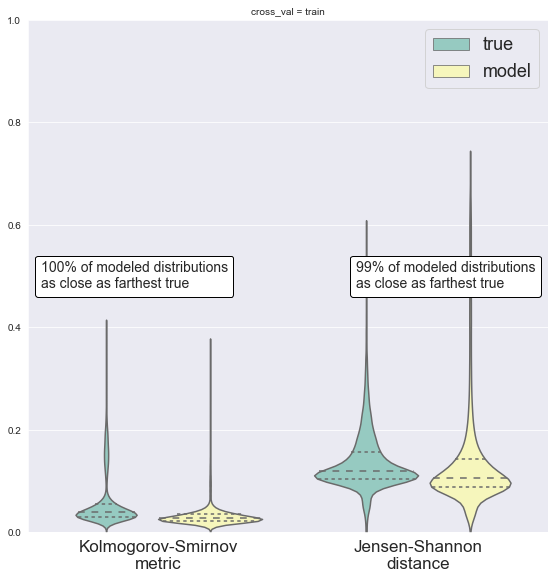

In [45]:
analysis.plot_single_stat_consistency_comparison()